In [198]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [199]:
import tensorflow_probability as tfp
norm = tfp.distributions.Normal(loc=0., scale=1.)
norm.pdf = norm.prob

# helper analytics
def bsPrice(spot, strike, vol, T):
    d1 = (tf.math.log(spot/strike) + 0.5 * vol * vol * T) / vol / tf.math.sqrt(T)
    d2 = d1 - vol * tf.math.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (tf.math.log(spot/strike) + 0.5 * vol * vol * T) / vol / tf.math.sqrt(T)
    return norm.cdf(d1) 

def bsVega(spot, strike, vol, T):
    d1 = (tf.math.log(spot/strike) + 0.5 * vol * vol * T) / vol / tf.math.sqrt(T)
    return spot * tf.math.sqrt(T) * norm.pdf(d1)

class BlackScholes:
        
    def __init__(self, 
                vol=0.2,
                T1=1.0, 
                T2=2.0, 
                K=1.10,
                volMult=1.5):
            
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                            
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
        
        tf.random.set_seed(seed)
            
        # 2 sets of normal returns
        returns = tf.random.normal(shape=[m, 2])
    
        # SDE
        vol0 = self.vol * self.volMult
        R1 = tf.exp(-0.5*vol0*vol0*self.T1 + vol0*tf.math.sqrt(self.T1)*returns[:,0])
        R2 = tf.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*tf.math.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 
    
        # payoff
        pay = tf.math.maximum(0, S2 - self.K)
            
        # two antithetic paths
        if anti:
                
            R2a = tf.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*tf.math.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = tf.math.maximum(0, S2a - self.K)
                
            X = S1
            Y = 0.5 * (pay + paya)
        
            # differentials
            Z1 =  tf.where(S2 > self.K, R2, 0.0)

            Z2 =  tf.where(S2a > self.K, R2a, 0.0) 
            Z = 0.5 * (Z1 + Z2)
                        
        # standard
        else:
            
            X = S1
            Y = pay

            # differentials
            Z =  tf.where(S2 > self.K, R2, 0.0)

        X = tf.reshape(X, [-1, 1])
        Y = tf.reshape(Y, [-1, 1])
        Z = tf.reshape(Z, [-1, 1])

        return X, Y, Z
        
    # test set: returns a grid of uniform spots
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
                
        spots = tf.linspace(lower, upper, num)
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1)
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1)
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1)

        spots = tf.reshape(spots, [-1, 1])
        prices = tf.reshape(prices, [-1, 1])
        deltas = tf.reshape(deltas, [-1, 1])
        vegas = tf.reshape(vegas, [-1, 1])

        return spots, spots, prices, deltas, vegas

In [200]:
bs = BlackScholes()
x_train, y_train, dydx_train = bs.trainingSet(10 * 8192)
x_test, x_axis, y_test, dydx_test, vegas = bs.testSet(num=1000)

# reshape x_train to 2D
# x_train = tf.reshape(x_train, [-1, 1])

In [201]:
def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test):
    plt.title("Training Data")
    # the same as plt.scatter(x_train, y_train) but with a thinner line is:
    plt.plot(x_train, y_train, 'r.', markersize=1)
    # now the other two with a thinner line:
    plt.plot(x_test, y_test, 'b.', markersize=1)
    plt.plot(x_train, dydx_train, 'g.', markersize=1)
    # plt.plot(x_axis, dydx_test, 'g.', markersize=1)
    # corresponding legend:
    plt.legend(['Training Data', 'True Price', 'Training Delta'], loc='upper left')
    plt.show()

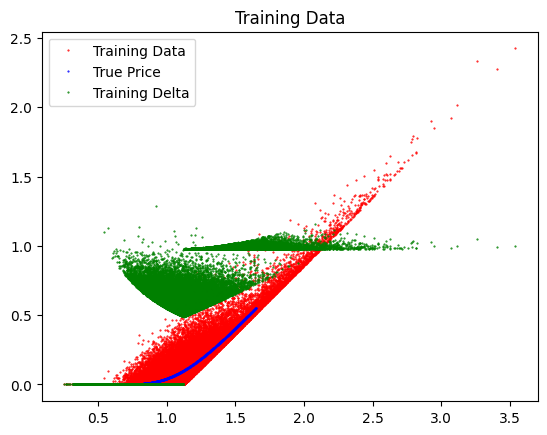

In [202]:
plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test)

In [203]:
print(x_train.shape, y_train.shape, dydx_train.shape)
print(x_test.shape, y_test.shape, x_axis.shape, dydx_test.shape, vegas.shape)

(81920, 1) (81920, 1) (81920, 1)
(1000, 1) (1000, 1) (1000, 1) (1000, 1) (1000, 1)


In [221]:
# prepare normalization layer for model
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(x_train)

x_train = normalizer(x_train)
x_test = normalizer(x_test)

In [205]:
print(normalizer(x_train).shape)
print(x_train.shape)


(81920, 1)
(81920, 1)


In [215]:

model = tf.keras.Sequential([
    # normalizer,
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1)
], name="SurrogateModel")

model.compile(optimizer='adam', loss='mse')

In [222]:
history = model.fit(x_train, y_train, epochs=4, batch_size=128, verbose=1, validation_data=(x_test, y_test))

Epoch 1/4
640/640 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 4.2714e-05
Epoch 2/4
640/640 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 1.3928e-04
Epoch 3/4
640/640 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 7.0338e-05
Epoch 4/4
640/640 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 4.9838e-05


In [223]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
8/8 [==============================] - 0s 2ms/step - loss: 4.9838e-05
test loss, test acc: 4.983802864444442e-05


32/32 [==============================] - 0s 1ms/step


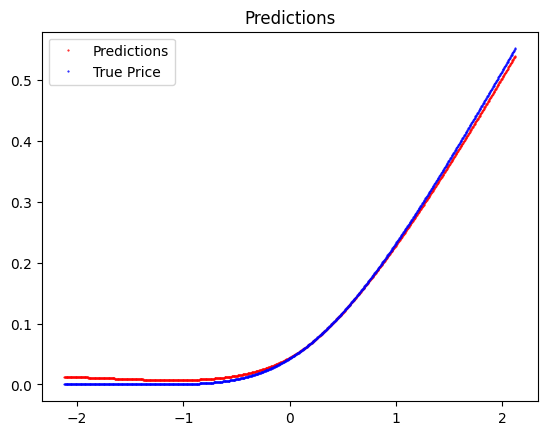

In [224]:

pred_y = model.predict(x_test)
plt.title("Predictions")
plt.plot(x_test, pred_y, 'r.', markersize=1)
plt.plot(x_test, y_test, 'b.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()


Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Evaluate on test data
32/32 [==============================] - 0s 1ms/step


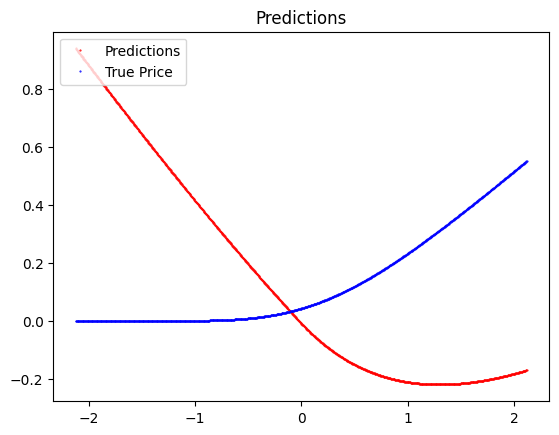

In [233]:
# create a new model
model = tf.keras.Sequential([
    # normalizer,
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1)
], name="SurrogateModelWithDifferentials")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# define the loss function
def loss(model, x, y, dydx):
    y_ = model(x)
    return tf.math.reduce_mean(tf.math.square(y_ - y)) #+ tf.math.reduce_mean(tf.math.square(dydx - tf.gradients(y_, x))) 

model.compile(optimizer=optimizer, loss=loss)

# define the training step
@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, dydx)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# train the model
for epoch in range(4):
    train_step(model, x_train, y_train, dydx_train)
    print('Epoch {} finished'.format(epoch))

print("Evaluate on test data")
# results = model.evaluate(x_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

pred_y = model.predict(x_test)
plt.title("Predictions")
plt.plot(x_test, pred_y, 'r.', markersize=1)
plt.plot(x_test, y_test, 'b.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()

In [234]:
bs = BlackScholes()
x_train, y_train, dydx_train = bs.trainingSet(10 * 8192)
x_test, x_axis, y_test, dydx_test, vegas = bs.testSet(num=1000)

In [317]:
NUM_EPOCHS = 4
BATCH_SIZE = 128
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1)
], name="SurrogateModelWithDifferentials")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def loss(y_pred, y_true, dydx_pred, dydx_true):
    return tf.math.reduce_mean(tf.math.square(y_pred - y_true)) #+ tf.math.reduce_mean(tf.math.square(dydx - tf.gradients(y_, x))) 

model.compile(optimizer=optimizer, loss=loss)

# transform into tf.data.Dataset:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

# shuffle and batch the datasets:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).take(STEPS_PER_EPOCH)
test_dataset = test_dataset.batch(BATCH_SIZE).take(STEPS_PER_EPOCH)

print(model)

@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as tape:
        y_pred = model(x)

        with tape.stop_recording():
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                dydx_pred = tape2.batch_jacobian(y_pred, x)

        pred_loss = loss(y_pred, y, dydx_pred, dydx)
        total_loss = pred_loss
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

for epoch in range(NUM_EPOCHS):
    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs)
    
    print('Finished epoch', epoch)


Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3


In [225]:
# creating a custom training loop

# create a new model
model = tf.keras.Sequential([
    # normalizer,
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1)
], name="SurrogateModel")

# create a new optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# create a new loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

# prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(128)

# lists for storing training and validation loss at each epoch
train_loss_results = []
val_loss_results = []

num_epochs = 4

for epoch in range(num_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_val_loss_avg = tf.keras.metrics.Mean()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    # Validation loop
    for x_val, y_val in val_dataset:
        val_loss_value = loss_fn(y_val, model(x_val))
        epoch_val_loss_avg.update_state(val_loss_value)

    val_loss_results.append(epoch_val_loss_avg.result())

    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Validation Loss: {:.3f}".format(epoch,
                                                                        epoch_loss_avg.result(),
                                                                        epoch_val_loss_avg.result()))
                                            
# plot the loss curves
plt.title("Loss Curves")
plt.plot(train_loss_results, label="Train")
plt.plot(val_loss_results, label="Validation")
plt.legend()
plt.show()

NameError: name 'grad' is not defined